<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/embedding_models/jina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

# Similarity search using Jina embeddings & Evaluating the Quality of Retrieved results using UpTrain

</div>


## What is a Vector Database?

Vector databases store data as high-dimensional vectors, enabling fast and efficient similarity search and retrieval of data based on their vector representations.

This is particularly useful for large language models (LLMs), which need to process vast amounts of data and find relevant information quickly.

## What role does Jina embeddings play in your RAG based application?

Jina Embeddings is a specialized embedding model, based on the Bert architecture (JinaBert), designed to support English text with a maximum sequence length of 8192 tokens. While working on RAG based applications, you can use Jina to retrieve information from your context documents.

Here is an [article](https://jina.ai/news/embeddings-in-depth/) explaining the embeddings and cosine similarity in detail for the jina vector embeddings

## Why do I need to monitor the retrieval quality?

Let's say a user asks your LLM application a question on refunds, maybe something like: "How can I initiate a refund on my last purchase?". Ideally, the retrieved context should contain two important pieces of information: "the user's last purchase" and "the company's policy on refunds". Now, what if the retrieved context doesn't contain that information or the fetched information is irrelevant. That's where UpTrain comes in, by helping you evaluate the relevance of the retrieved context.

## Overview of this notebooks

In this notebook, we will walk you through some basic applications in RAG, using Jina as a vector DB for your context documents. Subsequently, we will use UpTrain to evaluate the quality (relevance) of these retrieved contexts. For simplicity, we have divided this notebook into the following 3 parts:

1. **Data Preparation and Embedding:**
   We will begin by processing and embedding our data using a suitable sentence transformer model. This creates high-dimensional vector representations capturing the semantic meaning of each data point.

2. **Vector Search with Jina:**
   We will then leverage Jina's efficient vector search capabilities to retrieve relevant results based on a query vector, allowing us to explore the semantic relationships within the data.

3. **UpTrain Evaluation of Retrieved Content:**
   Utilizing UpTrain's pre-built and custom evaluation checks, we will analyze the quality of the retrieved search results. This assessment focuses on aspects such as context relevance, factual accuracy, and response completeness wrt context, providing valuable insights into the effectiveness of the search process.

## Step 1 : Install libraries and make necessary imports

In [1]:
# !pip install requests uptrain

In [2]:
import requests
import numpy as np

## Step 2: Define your document to be embedded

Let's make a similarity search for Sci-Fi books!


In [3]:
data = [
    {"text": "A Gift From The Stars. This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds. Written by Elena Dannan in 2020."},
    {"text": "The Time Machine. A man travels through time and witnesses the evolution of humanity. Written by H.G. Wells in 1895."},
    {"text": "Ender's Game. A young boy is trained to become a military leader in a war against an alien race. Written by Orson Scott Card in 1985."},
    {"text": "The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023."}
]


## Step 3: Choose your embedding model and get your api key from [here](https://jina.ai/embeddings/?ref=jina-ai-gmbh.ghost.io)


In [4]:

model_name = "jina-embeddings-v2-base-en"
api_key = "jina_****************"  # Replace with your Jina API key

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}



In [5]:
data_payload = {
    "input": data,
    "model": model_name
}

response = requests.post("https://api.jina.ai/v1/embeddings", json=data_payload, headers=headers)
embedding_vectors = np.array([item['embedding'] for item in response.json()['data']])  # Extract the embedding vectors from the response JSON



##Step 5: Compute the embedding vector for the question

In [6]:
question = "Which book covers the abduction story of Shreya Singh, a princess from Rajasthan"  # Replace with your actual input for similarity search

# Compute the embedding vector for the question
question_payload = {
    "input": [question],
    "model": model_name
}

response = requests.post("https://api.jina.ai/v1/embeddings", json=question_payload, headers=headers)
question_embedding = np.array(response.json()['data'][0]['embedding'])  # Extract the embedding vector from the response JSON

In [7]:
# Compute the cosine similarity between the question embedding and the text embeddings
similarities = np.dot(embedding_vectors, question_embedding) / (np.linalg.norm(embedding_vectors, axis=1) * np.linalg.norm(question_embedding))

In [8]:
# Print the text passages sorted by similarity to the question
embedding_similarities = []
for i in np.argsort(similarities)[::-1]:
    embedding_similarities.append({'text': data[i].get('text'), 'similartity': similarities[i]})

embedding_similarities

[{'text': 'The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023.',
  'similartity': 0.912475261534571},
 {'text': 'A Gift From The Stars. This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds. Written by Elena Dannan in 2020.',
  'similartity': 0.698555792085187},
 {'text': "Ender's Game. A young boy is trained to become a military leader in a war against an alien race. Written by Orson Scott Card in 1985.",
  'similartity': 0.6388188300107849},
 {'text': 'The Time Machine. A man travels through time and witnesses the evolution of humanity. Written by H.G. Wells in 1895.',
  'similartity': 0.6227105700723505}]

## Step 6: Evaluating the retrieved context's quality using UpTrain's Open-Source Software (OSS)

In [9]:
# Making a list of dictionary from 'data' using question and context

data_uptrain = []
for i in embedding_similarities:
    data_uptrain.append({'question': question, 'context': i.get('text')})

data_uptrain

[{'question': 'Which book covers the abduction story of Shreya Singh, a princess from Rajasthan',
  'context': 'The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023.'},
 {'question': 'Which book covers the abduction story of Shreya Singh, a princess from Rajasthan',
  'context': 'A Gift From The Stars. This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds. Written by Elena Dannan in 2020.'},
 {'question': 'Which book covers the abduction story of Shreya Singh, a princess from Rajasthan',
  'context': "Ender's Game. A young boy is trained to become a military leader in a war against an alien race. Written by Orson Scott C

In [10]:
from uptrain import EvalLLM, Evals, APIClient, Settings
import json

OPENAI_API_KEY = "sk-***************"  # Insert your OpenAI key here

eval_llm = EvalLLM(
    Settings(openai_api_key=OPENAI_API_KEY, response_format={"type": "json_object"})
)

res = eval_llm.evaluate(data=data_uptrain,
                        checks=[Evals.CONTEXT_RELEVANCE])

print(json.dumps(res, indent=3))

2024-02-12 19:31:25.522 | INFO     | uptrain.framework.evalllm:evaluate:113 - Sending evaluation request for rows 0 to <50 to the Uptrain


[
   {
      "question": "Which book covers the abduction story of Shreya Singh, a princess from Rajasthan",
      "context": "The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context directly addresses the question by mentioning the book 'The Royal Abduction' and providing details about the abduction story of Shreya Singh, a princess from Rajasthan. Therefore, the selected choice is (A)"
   },
   {
      "question": "Which book covers the abduction story of Shreya Singh, a princess from Rajasthan",
      "context": "A Gift From The Stars. This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Da

## Let's see the best context document fetched using Jina embeddings and UpTrain 

In [11]:
for i in embedding_similarities:
    if i['similartity'] == max([x['similartity'] for x in embedding_similarities]):
        print('Best Context Document according to cosine similarity: ')
        print(i['text'])

Best Context Document according to cosine similarity: 
The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023.


In [12]:
for i in res:
    if i['score_context_relevance'] == max([x['score_context_relevance'] for x in res]):
        print('Best Context Document according to cosine similarity: ')
        print(i['context'])

Best Context Document according to cosine similarity: 
The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023.


## [Optional] Step 7: UpTrain Managed Service and Dashboards


You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).


UpTrain Managed service provides:

1. Dashboards with advanced drill-down and filtering options
2. Insights and common topics among failing cases
3. Observability and real-time monitoring of production data
4. Regression testing via seamless integration with your CI/CD pipelines


In [13]:
UPTRAIN_API_KEY = "up-******************"  # Insert your UpTrain API key here

uptrain_client = APIClient(
    Settings(
        uptrain_access_token=UPTRAIN_API_KEY, response_format={"type": "json_object"}
    )
)

res = uptrain_client.log_and_evaluate("jina-context-sample-evals",
                                      data = data_uptrain, 
                                      checks = [Evals.CONTEXT_RELEVANCE]
)

print(json.dumps(res, indent=3))

2024-02-12 19:31:26.429 | INFO     | uptrain.framework.remote:log_and_evaluate:623 - Sending evaluation request for rows 0 to <50 to the Uptrain server


[
   {
      "question": "Which book covers the abduction story of Shreya Singh, a princess from Rajasthan",
      "context": "The Royal Abduction. Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past. Written by Vikram Singh in 2023.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context directly addresses the question by mentioning the book 'The Royal Abduction' and providing details about the abduction story of Shreya Singh, a princess from Rajasthan. Therefore, the selected choice is (A)"
   },
   {
      "question": "Which book covers the abduction story of Shreya Singh, a princess from Rajasthan",
      "context": "A Gift From The Stars. This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Da

### Dashboards: 
Histogram of score vs number of cases with that score

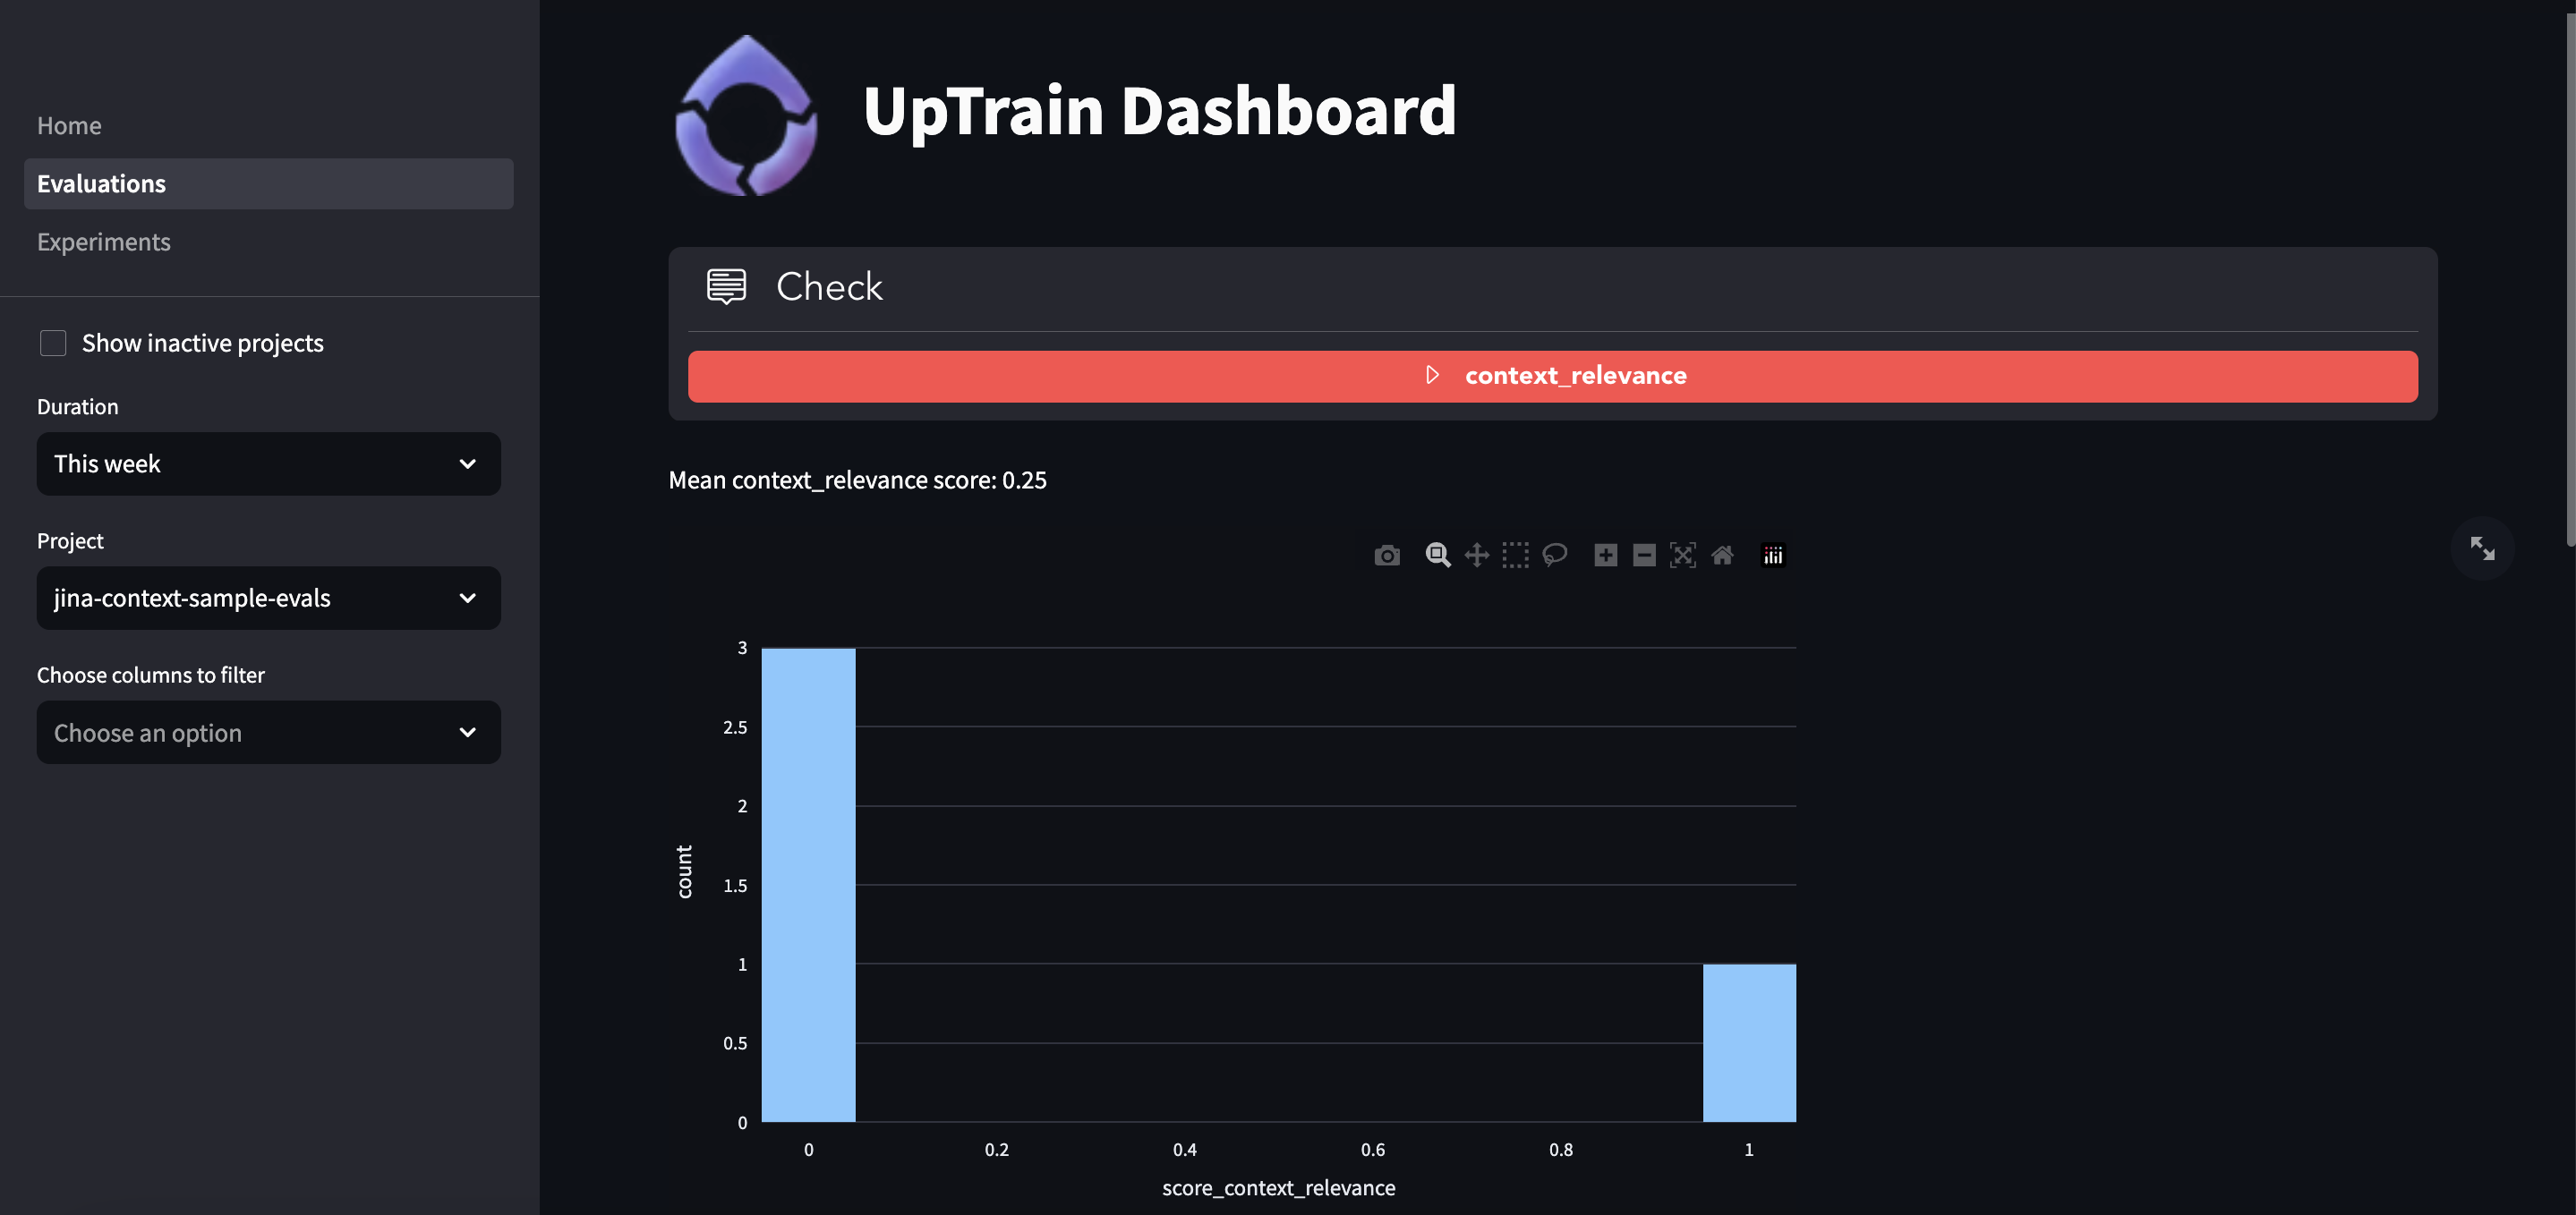

### Insights:
You can filter failure cases and generate common topics among them. This can help identify the core issue and help fix it

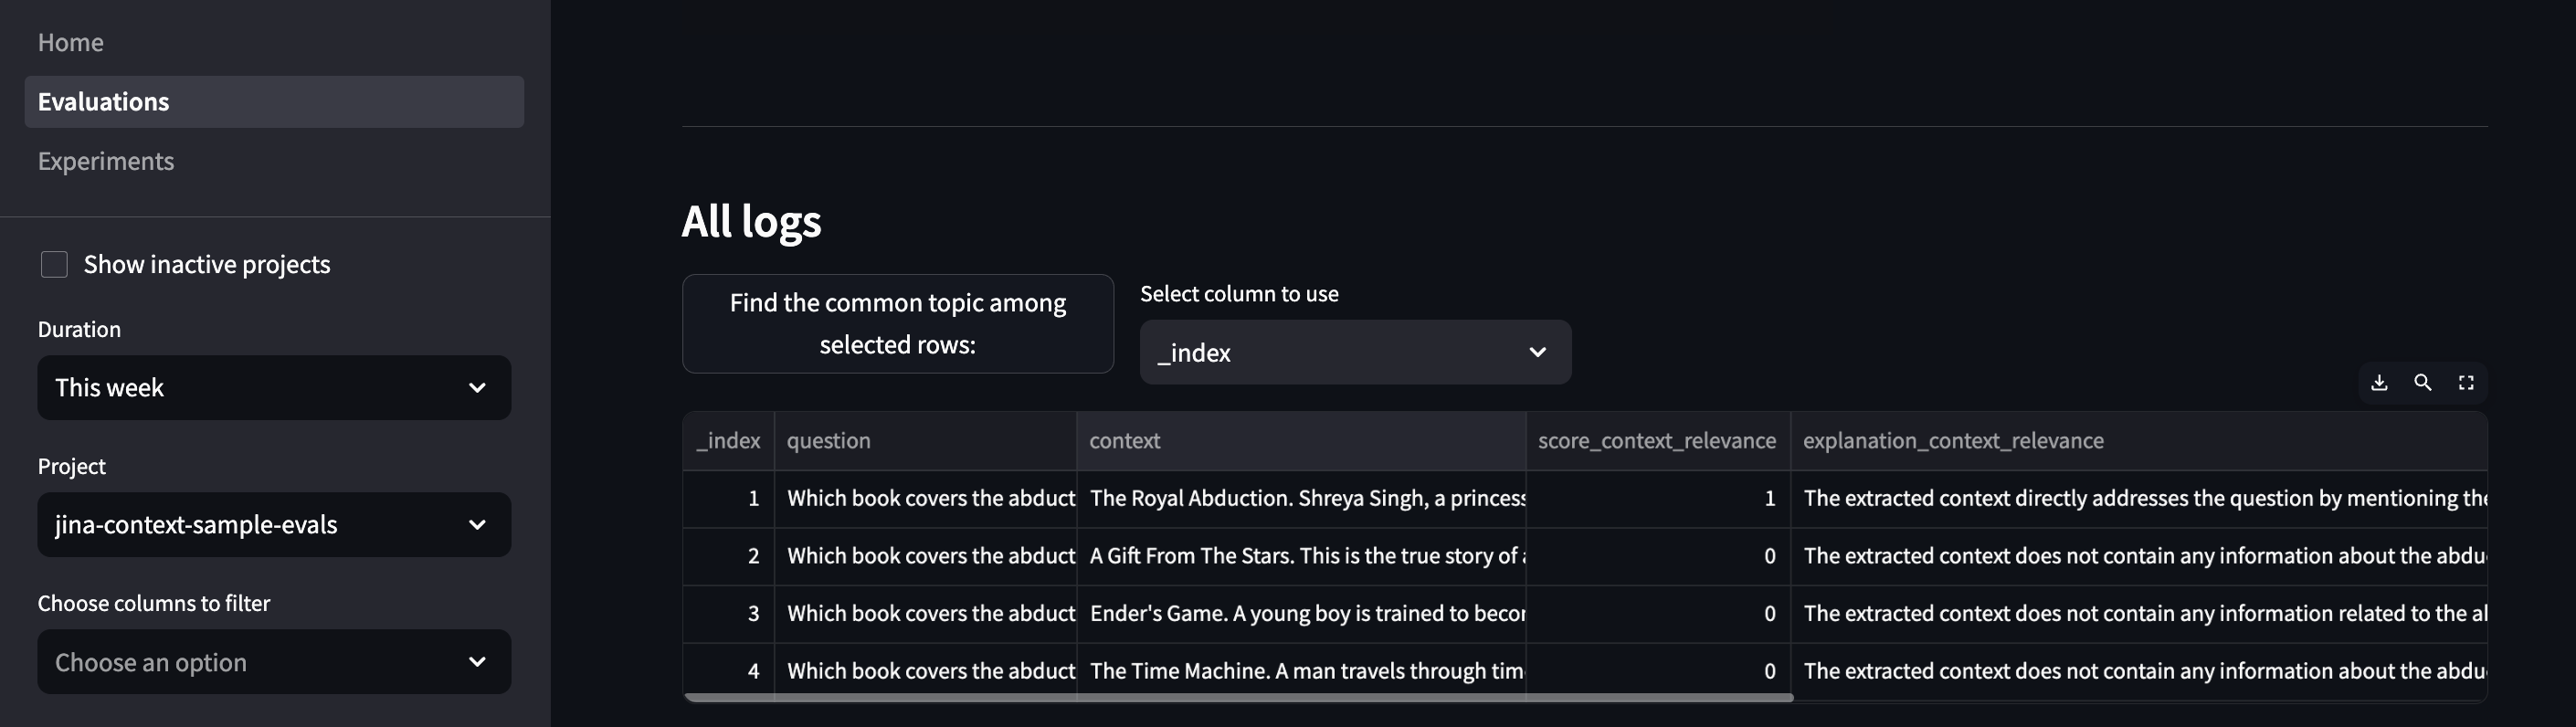